# Looking at the dataset structure
Since the dataset was not created by us, but has been obtained by an external source, before start to model the data, it is necessary understand all the variables contained the file and do some checks in order to detect possible errors or outliers

In [1]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import pylab as pl
from matplotlib.gridspec import GridSpec
%matplotlib inline
import seaborn as sns


In [2]:
beer = pd.read_csv("../df_beers.csv", sep =",")
beer.head(3)

,Unnamed: 0,Unnamed: 0.1,names,Id,brewerId,ABV,style,appearance,aroma,palate,taste,overall,time,profile_name,text,time2,day,month,year,user_id
0,0,0,Sausa Weizen,47986,10325,5.0,Hefeweizen,2.5,2.0,1.5,1.5,1.5,1234817823,stcules,""" A lot of foam. But a lot.\tIn the smell some...",2009-02-16,16,2,2009,30561
1,1,1,Red Moon,48213,10325,6.2,English Strong Ale,3.0,2.5,3.0,3.0,3.0,1235915097,stcules,""" Dark red color, light beige foam, average.\t...",2009-03-01,1,3,2009,30561
2,2,2,Black Horse Black Beer,48215,10325,6.5,Foreign / Export Stout,3.0,2.5,3.0,3.0,3.0,1235916604,stcules,""" Almost totally black. Beige foam, quite comp...",2009-03-01,1,3,2009,30561


## How many data do we have?, How is our dataset structure   
There are 104 styles of beer, and 5.840  brewers companies which supply 56.845 different beers. The Id is an unique identify for each beer, so if there are more Ids (66.036) than names of beers means that we have cases with same style, same supplier and same name of beer but labeled with different Id

#### Hierarchy   
1.Style --> 104   
2.BrewerId --> 5840   
3.Names --> 56845   
4.Id --> 66036

In [3]:
# total customers
customers=beer['profile_name'].nunique()
# total beers by style
beer_style=beer['style'].nunique()
# total beers by Id
beer_Id=beer['Id'].nunique()
# total beers by brewerId
beer_brewerId=beer['brewerId'].nunique()

original="The dataset has {} customers,".format(customers), "{} styles of beer,".format(beer_style), "and {} beers".format(beer_Id)
print original

('The dataset has 33381 customers,', '104 styles of beer,', 'and 66036 beers')


## Question 1: 
### We have less names than Ids. Are there beers with the same name, style and same brewerId, but different Id? 
As we have seen, there are 56.845 names of beers and 66.036 Ids. There must be an explanation for those names having more than one Id.   
Grouping by the names, we can see how there are names of beer with more than 100 different ID, e.g Oktoberfest. Instead of one name = one ID 


In [4]:
brand_by_name=beer.groupby('names')['Id'].nunique()
brand_by_name.sort_values(ascending = False).head(10)

names
 Oktoberfest       199
 Pale Ale          198
 Oatmeal Stout     161
 IPA               147
 Hefeweizen        143
 India Pale Ale    140
 Porter            107
 Maibock           101
 Imperial Stout     95
 Amber Ale          86
Name: Id, dtype: int64

### Eg,name of beer = Oktoberfest has 199 Ids. Why?

In [5]:
## the beer called Oktoberfest has 5 different styles
brand_study=beer.groupby(['names']).get_group(' Oktoberfest')['style'].nunique()
brand_study

5

In [6]:
brand_study=beer.groupby(['names']).get_group(' Oktoberfest')
brand_by_name2=brand_study.groupby(['style'])['Id'].nunique()
brand_by_name2

style
 American Amber / Red Ale        1
 American Amber / Red Lager      1
 American Dark Wheat Ale         1
 Märzen / Oktoberfest          194
 Vienna Lager                    2
Name: Id, dtype: int64

### Checking the Märzen / Oktoberfest style which has 194 Ids
- **It could be that the Id changes within the same beer name and style attending to the ABV variable**   
- Same name, same style, differents Ids (probably the ABV has something to do with it)   
- Is it possible that differents brewer company have the same name of beer?   

In [7]:
brand_by_name3=brand_study.groupby(['style','ABV'])['Id'].nunique()
brand_by_name3.head(7)

style                        ABV 
 American Amber / Red Ale    99.0    1
 American Amber / Red Lager  5.4     1
 American Dark Wheat Ale     5.2     1
 Märzen / Oktoberfest        3.8     1
                             4.3     1
                             4.8     1
                             4.9     3
Name: Id, dtype: int64

###  Ids are related with the ABV
- Most of the Ids are concentrate on the variable ABV = 99 (we recoded those null fields with a 99 code). This reaffirms the theory that one beer with the same style and the name, can  have different Ids attending to its alcoholic graduation.  
- Let's check now, the  beer that has 6 degrees and 15 differents Ids. By doing a few filters, we can verify that these beers belong to 15 different breweries and therefore we can say that our data are correct (they have sense)

In [8]:
marzen=beer[(beer['style'] == " Märzen / Oktoberfest") & (beer['names'] == " Oktoberfest")  & (beer['ABV'] == 6)]
marzen2=marzen.groupby(['brewerId'])['Id'].nunique()
marzen2

brewerId
144      1
395      1
959      1
1683     1
2310     1
2454     1
2599     1
3925     1
4426     1
10567    1
11936    1
15205    1
21683    1
22035    1
24791    1
Name: Id, dtype: int64

# Most popular beers
### Styles of beer more offered by the brewers and styles most rated by the customers

In [9]:
# Num of beers (brand/names) broup by style
num_beers_by_style=beer.groupby('style').agg({'names':'nunique','Id':'nunique'})
num_beers_by_style.reset_index(inplace=True)
num_beers_by_style = num_beers_by_style.rename(columns={'names': 'total_beers', 'Id': 'total_beers_Id'})
num_beers_by_style.sort_values(by=['total_beers_Id'], ascending=False).head()

,style,total_beers,total_beers_Id
12,American IPA,3167,3611
14,American Pale Ale (APA),2886,3348
2,American Amber / Red Ale,2230,2510
17,American Porter,1839,2198
60,Fruit / Vegetable Beer,1603,1836


### Below are some graphs to visualize best the data structure
As we can see in the plots, the value of the median (that is, the value that centers the distribution, 50% of the styles) is around 400 beers. The boxplot shows 5 extremely high values that we should check with more detail

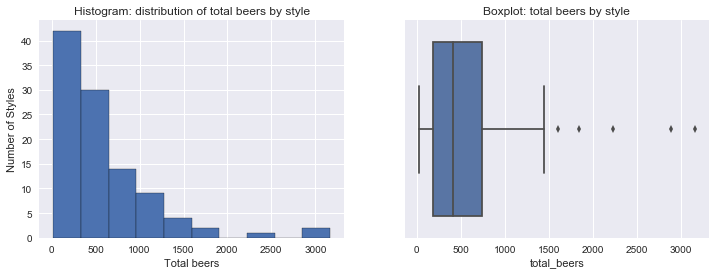

In [10]:
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust()

ax1 = plt.subplot2grid((1,2), (0,0))
#sns.distplot(num_beers_by_style["total_beers"], bins=50, kde=False).set_title('Histogram: total beers by style')

plt.hist(num_beers_by_style["total_beers"], bins=10,  alpha=1, histtype='bar', ec='black')
plt.ylabel('Number of Styles')
plt.xlabel('Total beers')
plt.title(r'Histogram: distribution of total beers by style')

ax2 = plt.subplot2grid((1,2), (0,1))
sns.boxplot(x=num_beers_by_style["total_beers"]).set_title('Boxplot: total beers by style')

In [11]:
top5_beers_by_style=num_beers_by_style.sort_values(by=['total_beers_Id'], ascending=False).head(5)

In [12]:
top5_beers_by_style['percentage']=top5_beers_by_style.total_beers_Id/top5_beers_by_style.total_beers_Id.sum()*100
top5_beers_by_style.sort_values(by=['percentage'], ascending=False).head()
pd.options.display.float_format = '{:,.0f}'.format
top5_beers_by_style

,style,total_beers,total_beers_Id,percentage
12,American IPA,3167,3611,27
14,American Pale Ale (APA),2886,3348,25
2,American Amber / Red Ale,2230,2510,19
17,American Porter,1839,2198,16
60,Fruit / Vegetable Beer,1603,1836,14


#### Again the long tail of the violin plot shows that 5 high values

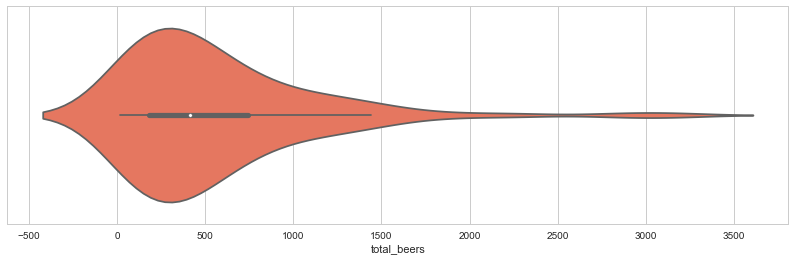

In [13]:
fig = plt.figure(figsize=(14,4))
sns.set_style("whitegrid")
ax = sns.violinplot(x=num_beers_by_style["total_beers"], palette="Reds") 

In [14]:
num_beers_by_style['total_beers'].describe()

count     104
mean      566
std       558
min        19
25%       183
50%       411
75%       742
max     3,167
Name: total_beers, dtype: float64

#### Distribution of styles 
Let's breaking down the data by the mean value
* Styles that have between 19 and 411 beers (50% of the total distribution = 52 styles) 
* Styles that have between 411 and 3167 (the other 50%)

The greatest dispersion and asymmetry is shown in graph number 2

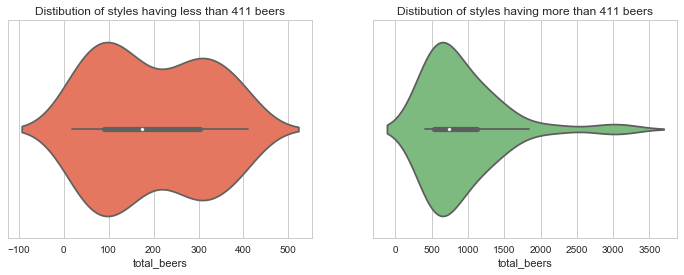

In [15]:
less_than_mean = num_beers_by_style[num_beers_by_style['total_beers']<411]
more_than_mean = num_beers_by_style[num_beers_by_style['total_beers']>=411]

fig = plt.figure(figsize=(12,4))
fig.subplots_adjust()

ax1 = plt.subplot2grid((1,2), (0,0))
ax1 = sns.violinplot(x=less_than_mean["total_beers"], palette="Reds").set_title('Distibution of styles having less than 411 beers')

ax2 = plt.subplot2grid((1,2), (0,1))
ax2 = sns.violinplot(x=more_than_mean["total_beers"], palette="Greens").set_title('Distibution of styles having more than 411 beers')


#### Beers most rated/consumed by style

In [16]:
most_rated_style=beer.groupby('style').agg({'profile_name':'nunique'})
most_rated_style.reset_index(inplace=True)
most_rated_style = most_rated_style.rename(columns={'profile_name': 'total_customers'})
most_rated_style.sort_values(by=['total_customers'], ascending=False).head()

,style,total_customers
12,American IPA,12479
9,American Double / Imperial IPA,10977
14,American Pale Ale (APA),9252
89,Russian Imperial Stout,8990
17,American Porter,8464


In [17]:
top5_styles_by_customer=most_rated_style.sort_values(by=['total_customers'], ascending=False).head(5)

In [18]:
top5_styles_by_customer['percentage']=top5_styles_by_customer.total_customers/top5_styles_by_customer.total_customers.sum()*100
top5_styles_by_customer.sort_values(by=['percentage'], ascending=False).head()
pd.options.display.float_format = '{:,.0f}'.format
top5_styles_by_customer

,style,total_customers,percentage
12,American IPA,12479,25
9,American Double / Imperial IPA,10977,22
14,American Pale Ale (APA),9252,18
89,Russian Imperial Stout,8990,18
17,American Porter,8464,17


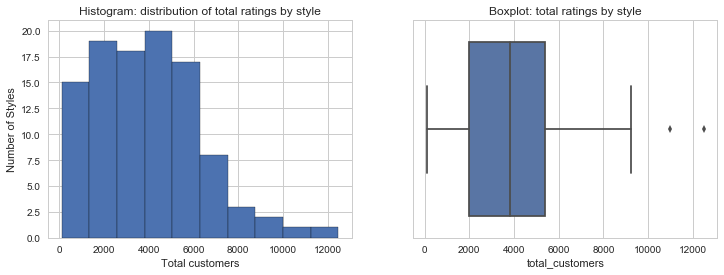

In [19]:
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust()

ax1 = plt.subplot2grid((1,2), (0,0))
plt.hist(most_rated_style["total_customers"], bins=10,  alpha=1, histtype='bar', ec='black')
plt.ylabel('Number of Styles')
plt.xlabel('Total customers')
plt.title(r'Histogram: distribution of total ratings by style')

ax2 = plt.subplot2grid((1,2), (0,1))
sns.boxplot(x=most_rated_style["total_customers"]).set_title('Boxplot: total ratings by style')

### Styles of beer more offered by the brewers
**American IPA style** has 3.167 different type of beers, and the **American Pale Ale** has 2.886. These two are the styles of beer more offered by the brewers.

### Most rated/consumed by the customers
The **IPA style**, following by the **Imperial IPA style**, are the most rated/consumed by the customers (with 12.479 and 10.977 ratings respectively)

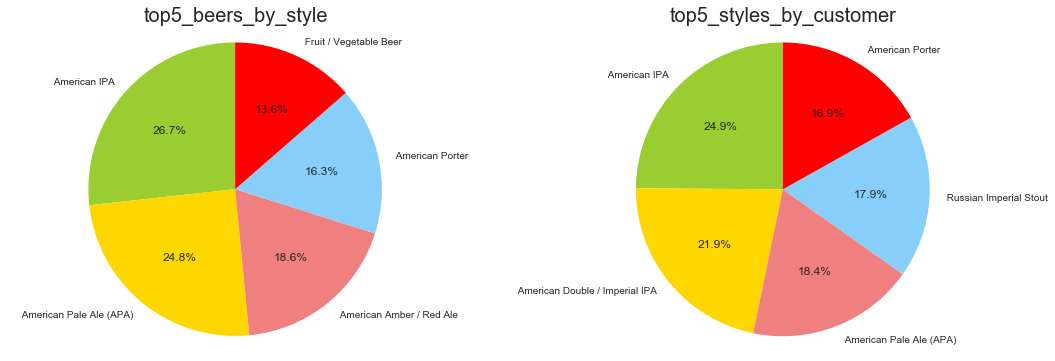

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2)
labels = top5_beers_by_style['style']
sizes = top5_beers_by_style['percentage']
labels2 = top5_styles_by_customer['style']
sizes2 = top5_styles_by_customer['percentage']
colors = ['yellowgreen', 'gold', 'lightcoral', 'lightskyblue', 'red']

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.axis('equal')
ax1.set_title('top5_beers_by_style',fontsize=20)
ax2.pie(sizes2, labels=labels2, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.axis('equal') 
ax2.set_title('top5_styles_by_customer',fontsize=20)

fig = plt.gcf()
fig.set_size_inches(18,6)
plt.show()

The "total beers by style" boxplot showed  5 extremely high values. After check the top 5 beers offered by the brewers and the top 5 beers consumed by the customers (pie charts above) **we will not considerer these 5 extremly values as outliers** since 2 of these 5 styles (American Pale Ale and American IPA) are most popular among consumers. So it makes sense for beer companies to offer more brands within those styles

# Customers behaviour
## Question 2:    
### Is it possible that there are customers who have rated more than 100 beers in one day?
- It could be that they make annotations and then rate all the beers that they tested at once
- It could be a profile_name of a shop, or it can corresponds to a event.   
- Also we can see how there is a profile name labeled as BeerAdvocate which is the name of the website (from where we took the data). So it could be a good idea to take it out.   

Let's check the data in more detail

In [21]:
beers_each_day=beer.groupby(['profile_name', 'year', 'month', 'day']).agg({'names':'nunique'})
beers_each_day.reset_index(inplace=True)
beers_each_day = beers_each_day.rename(columns={'names': 'beers_by_day'})
beers_each_day.sort_values(by=['profile_name'], ascending=False).head(10)

,profile_name,year,month,day,beers_by_day
869695,zzajjber,2009,11,13,1
869694,zyzygy,2006,5,18,2
869693,zyzygy,2006,3,6,1
869692,zyzygy,2006,3,2,1
869691,zyzygy,2006,2,3,1
869685,zythus,2009,3,21,3
869690,zythus,2010,2,25,1
869689,zythus,2009,5,31,1
869688,zythus,2009,5,13,1
869687,zythus,2009,5,4,1


In [22]:
beers_each_day.sort_values(by=['beers_by_day'], ascending=False).head(10)

,profile_name,year,month,day,beers_by_day
279939,RblWthACoz,2007,12,30,357
279940,RblWthACoz,2007,12,31,252
279941,RblWthACoz,2008,1,1,246
210651,LilBeerDoctor,2010,12,23,215
655744,magictrokini,2008,12,5,214
655747,magictrokini,2008,12,10,214
177081,JDV,2008,4,6,176
473842,changeup45,2008,8,24,173
177085,JDV,2008,6,30,168
863086,yesyouam,2008,12,20,168


- The customer who rated more beers in one day is _"RblWthACoz"_ .Another one that rated a lot of beers in different days is called _"JDV"_.   
- We can check the **customer comments to see if they are different  over all their ratings** (if they are quite similar or equal , it could means that they are not from a real customer)
- In order to have an idea of if their **ratings are real ones** or look like they **belong to a store** or they comming from a kind of **automatic scoring**   
- If we have into account the **ratio between the ratings per day and the total ratings of each customer**, we can check if the higher rating days are a normal behavior of the customer or an outlier

### RblWthACoz comments: it seems that they are differents

In [23]:
pd.options.display.max_colwidth = 1000
customer1=beer.loc[beer['profile_name'] == ' RblWthACoz',['text']]
customer1

,text
2484,""" Pours a clear, but darker ruby hued brown. Thin light tan head. Flavor is sweet, and too much so I have to say. Calms down a bit over time, but the memory of it sticks with me. Fruit tones and a tart bitterness ride on the backside of things. Feel is slick on liquid and the carbonation is slightly subdued. This is an okay beer. As it warms it's initially abrasive qualities seem to calm down a bit and I enjoy it more than I thought I would.\t\t"""
2485,""" Quite the schnazzy label we've got here. \t\tPours a foggy orange gold with a decent off-white head. Nose is like fruit that's been sitting out too long. Wow. Flavor is clearly smoked. This is like a rauchbier, yet Belgian in style. Defined meat tones and smoky as well. As I drink more of it, I see where it comes from on the nose. Besides everything else so far, there is a clear sweet edge with fruit tones as well. As time goes on the rauch qualities fade away and a sweet tone really sets in. Yet occasionally the rauch character hits me in the back of the mouth as an aftertaste ever so subtly. Feel is slick and smooth, yet a bit thick, on liquid. Carbonation is middle of the road. Well this was an interesting beer. I definitely suggest you try it if you have the chance.\t\t"""
2487,""" Pours a foggy orange with a brown touch and a thicker light head. Nose is like citrus rinds and concentrated orange as well. Flavor is intense orange, almost like the flavor of Tang. A bit too much IMO. Feel has a fuller carbonation. Liquid is about right. This beer just doesn't work for me. Way too much tang and unbalanced.\t\t"""
2488,""" Pours a foggy orange gold with a decent sized crme head. Nose is quite sweet, but not overpowering. Definite citrus as well. Flavor is interestingly complex. Sweet tones are firmly there with numerous fruit layers. Feel is a bit thicker on liquid. Carbonation is full enough, though not abrasive. I like this beer. Quite tasty and a pleasure to drink.\t\t"""
2989,Pours a slightly hazed orange amber. Nose is a lot of dough and spices. Flavor is tangy with citrus. Nice level of sweetness. Spices are backing it up. Smooth and nice really. Much better than I was expecting. Feel is smooth on liquid. But the one detractor is the carbonation. A bit too much IMO. However. This is still a pretty tasty brew.\t\t
3229,""" Pours a clear very dark amber with brown and reddish tints. Minimal tannish head doesn't really stay long, but leaves decent lacing on the way down. Nose is super floral hops. Strong and unrelenting. Flavor is very strong. Acidic almost at first. Firm woody edges. Very, very earthy. Feel is sticky on liquid and the carbonation is good. Surprisingly, this ends up being a pretty drinkable DIPA as I tore through the bottle and was finished well before I wished. A nice DIPA, though a bit heavy on the robust side.\t\t"""
3874,""" Pours a clear amber with a full creme head that sticks around and leaves nice lace on the way down. Nose is hoppy, of course, but has a soapy edge. Overall fragrances are not very powerful and carry very minor pine character. Flavor is smooth. Balanced bitter tones with noticeable leafy and woody hop tones, though not firm or anywhere near overpowering. Seems like some alcohol is there as well. Feel is nice. Pretty full carbonation on a slick liquid feel. This is a nice drinker. More woody than most other things. I think this on cask would be interesting.\t\t"""
5568,""" Pours pitch black and thick with a smaller dark tan head that forms and falls to nothing. No lacing. Malty tones on the nose. Extremely slight amount of roasted edge to it. Flavor is extremely smooth. Unbelievably smooth. Thick malts accented by mild oat. Sweet tone almost like a molasses that's more smooth and sweet than thick and bitter with a biting edge. Man, oh man. Very mild amount of alcohol biting on the back side. On the aftertaste I feel it burning just a slight bit as well. Feel is thick on liquid and carries a low, but smooth enough carbon

### JDV it seems that they are differents

In [24]:
pd.options.display.max_colwidth = 1000
customer2=beer.loc[beer['profile_name'] == ' JDV',['text']]
customer2

,text
605,""" Can from Beerzack. Thanks!\tPours Semi-clear reddish amber witha big lasting chunky whitish head that leaves lots of lacing. Smell is sweet fruity, fresh and hoppy. Very nice. Taste is smooth with fruity caramel and fresh citrusy, and sweet orange flavored hops and bitter citrus rind. Nice and strongly bittered which lasts in the finish but with a light lingering sweetness too. Very good IPA.\t\t"""
926,""" Bottle shared with Fly, Dewbrewer, Humulone_Red and others. Thanks guys!\tPours a glowing orange with no head. Funky nose reminiscent of gooey band-aids. Odd taste with sweet guaze like flavor. No carbonation on it either, and this one just wasn't for me.\t\t"""
1104,""" Pours pale yellow with almost no head. Smell is sweet with corn and maltiness in the taste. Very carbonated, and light, obviously, easy to drink, and tastes decent enough. Nothing spectacular, but I don't get all the really low ratings. This wasn't supposed to be a big bold beer that turned out light. Rating it for what it is, this is good for the style.\t\t"""
3004,""" Shared at tasting, courtesy of Beervirgin72. Thank you! \tPours a rich cloudy goldish color with a light whitish head. Smell is yeasty and wheaty, but without much clove or spiced characteristic. Taste is wheat, honey, yeast, and lemon and feels more like a cross between an American Wheat and a German Hefeweizen, leaning on the American Wheat side, I thought. Very crisp, and drinkable, with a milder characteristic yeast flavor than most hefs. Nice beer!\t\t"""
3208,""" Bottle from Miketd. Thanks for this one, Mike! Pours rich dark amber with a big creamy beige head in a tulip. Smell is fruity, sweet, and light piney hops and a bit of alcohol, and some caramel sweetness. Taste is creamy, rich and balanced for the style with an emphasis on hops of course. Nicely hopped but lightly caramelly sweet on the backend with a bit of an alcohol presence in the flavor. Very nice, and drinkable DIPA I thought, and a very well made beer.\t\t"""
3869,""" Big thanks to miketd for the bottle.-\tRich but transluscent copper with a lasting off white foamy head. Smell is not as hoppy as expected initially, and more of toffee sweetness, as in an ESB, plus a touch of floral hoppiness. Somewhat of a cantaloupe melony nose after it warms too. Carbonated body, with a more malty than average taste for an IPA, with some light hops and a creaminess to the body despite the slightly bubbly carbonation. A touch of light pepperiness to it as well. Nice IPA overall.\t\t"""
5526,""" Big thanks to Miketd for the bottle!\tPours a solid dark black with a nice sized creamy but somewhat short lived tan head into a snifter. Smell was big and of oatmeal sweetness, dark roasted malt and I got a big fire roasted marshmallow gooeyness out of it as well. Taste was also fantastic, very nice roasty character with oatmeal creaminess and chewiness making an obvious presence. Very full mouthfeel, and on the sweeter side of an imperial stout, which I tend to like. I got a big marshmallow like character in the taste as well and overall this was an amazing beer. The hint of alcohol that shows as it warms was pretty mild and unobtrusive.\t\t"""
5867,""" Bottle courtesy of miketd. Thanks man! Pours nice and black with a lasting, creamy tan head. Smell is dusty bittersweet chocolate and dark cherry fruitiness. Taste is bittersweet chocolate and dark fruitiness. Leaning on the sweet side with a chocolate covered cherry flavor. Creamy soft carbonation and a semi-rich body. Very easy drinking. Really nice.\t\t"""
7066,""" Mahogany dark amber color with lacing and white head. Smell of dark malt mostly. A touch of bitterness, toasty malt, but a bit watery though, and light coffee flavors even. Different for a bock, I thought, and ok, but nothing to get too excited about.\t\t"""
7067,""" Pale hazy yellowish pour. Taste was what you'd expect from a hefeweizen to me, and was clovey and spiced. I thought it was boring, and average, and not d

In [25]:
df=pd.merge(beer, beers_each_day)
df.shape

(1585827, 21)

### We are not include those customers that rated more than 10 beers each day

Let's recode those customers that have rated more than 10 beers by day because we don't want to have weird results in our algorithm. We considerer that taste or rate more than 10 beers for several days is an "abnormal" behaviour

In [26]:
def recode(row):
    if row['beers_by_day'] >=10:
        val = 1
    else:
        val = 0
    return val

In [27]:
df['more_beers_than_10'] = df.apply (recode, axis=1)

In [28]:
more_than_ten=df.groupby(['profile_name']).agg({'more_beers_than_10':'sum'})
more_than_ten.reset_index(inplace=True)
more_than_ten = more_than_ten.rename(columns={'more_beers_than_10': 'too_much_beers'})
more_than_ten.sort_values(by=['too_much_beers'], ascending=False).head(10)

,profile_name,too_much_beers
12374,Thorpe429,2368
26922,northyorksammy,1828
32906,womencantsail,1753
8552,Mora2000,1681
7593,LilBeerDoctor,1595
7269,Knapp85,1534
25699,mikesgroove,1500
21339,hopdog,1296
14925,beerguy101,1260
10129,RblWthACoz,1126


In [29]:
df=pd.merge(df, more_than_ten, on='profile_name')

In [30]:
df.shape

(1585827, 23)

In [31]:
df.filter(items=['profile_name', 'too_much_beers', 'day', 'names']).head()

,profile_name,too_much_beers,day,names
0,stcules,180,16,Sausa Weizen
1,stcules,180,16,San Gabriel Bionda
2,stcules,180,1,Red Moon
3,stcules,180,1,Black Horse Black Beer
4,stcules,180,1,San Gabriel Ambra Rossa Di Treviso


In [32]:
df_final=df[(df.too_much_beers == 0) ]

In [33]:
df_final.shape

(830442, 23)

## Final dataset after clean the data

Once we remove those customers with a weird behaviour, our dataset has 31.651 customers. 1.730 less than the original

In [34]:
# total customers
customers=df_final['profile_name'].nunique()
# total beers by style
beer_style=df_final['style'].nunique()
# total beers by Id
beer_Id=df_final['Id'].nunique()
# total beers by brewerId
beer_brewerId=df_final['brewerId'].nunique()

final= "The final dataset has {} customers,".format(customers), "{} styles of beer,".format(beer_style), "and {} beers".format(beer_Id)

print (original)
print (final)

('The dataset has 33381 customers,', '104 styles of beer,', 'and 66036 beers')
('The final dataset has 31651 customers,', '104 styles of beer,', 'and 40424 beers')


In [35]:
df_final.to_csv('df_clean.csv')